
# Week 3 - Discovering higher-level Patterns (Topic Modeling & Clustering)

The first 2 weeks have primarily used the word count of documents as their measure, such as counting the number of "positive" and "negative" words to determine sentiment.

This week, we learn a second kind of document representation in clusters or topics. First, we take a text corpus that we have developed and discovery emergent clusters through a process known as clustering or partitioning. We pilot this here both with a well-known *flat* clustering method, `kmeans`, and also a *hierarchical* approach, `Ward's (minimum variance) method`. We will demonstrate a simple (graphical) approach to identifying optimal cluster number, the sillhouette method, and evaluate the quality of unsupervised clusters on labeled data. Next, we will explore a method of two dimensional content clustering called topic modeling (e.g., words cluster in topics; topics cluster in documents). This statistical technique models and computationally induces *topics* from data, which are sparse distributions over (nonexclusive clusters of) words, from which documents can formally be described as sparse mixtures. We will explore these topics and consider their utility for understanding trends within a corpus. We will consider how to construct models that take document cluster and topic loadings as predictive features, the basis of influence metrics and dynamically over time.

For this notebook we will be using the following packages:

In [2]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git


#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

# Getting our corpora

To begin, we will use a well known corpus of testing documents from the *20 Newsgroups corpus*, a dataset commonly used to illustrate text applications of text clustering and classification. This comes packaged with sklearn and comprises approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 newsgroups. It was originally collected by Ken Lang, probably for his 1995 *Newsweeder: Learning to filter netnews* paper. The data is organized into 20 distinct newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related (e.g. comp.sys.ibm.pc.hardware / comp.sys.mac.hardware), while others are unrelated (e.g misc.forsale / soc.religion.christian). 

In [ ]:
newsgroups = sklearn.datasets.fetch_20newsgroups(subset='train', data_home = '../data/scikit_learn_data')
print(dir(newsgroups))

We can ascertain the categories with `target_names` or the actual files with `filenames`

In [ ]:
print(newsgroups.target_names)
print(len(newsgroups.data))

We will start by converting the provided data into pandas DataFrames.

First we reduce our dataset for this analysis by dropping some extraneous information and converting it into a DataFrame.

In [ ]:
newsgroupsCategories = ['comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos']

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])

for category in newsgroupsCategories:
    print("Fetching data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(subset='train', categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data/scikit_learn_data/')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

#Creating an explicit index column for later

#newsgroupsDF['index'] = range(len(newsgroupsDF))
#newsgroupsDF.set_index('index', inplace = True)
print(len(newsgroupsDF))
newsgroupsDF[:10]

Next, we can convert the documents into word count vectors (e.g., *soc.religion.christian message a* might contain 3 mentions of "church", 2 of "jesus", 1 of "religion", etc., yielding a CountVector=[3,2,1,...])

In [ ]:
#First it needs to be initialized
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
newsgroupsVects = ngCountVectorizer.fit_transform(newsgroupsDF['text'])
print(newsgroupsVects.shape)

I'm pretty sure that you're very familiar with the cell above now, but let's go through the concepts again. 

What do we want to do here? We want to do vectorization, i.e., converting texts into numerical features (vectors) as required by machine learning algorithms. And this is what feature_extraction module does: to extract features from texts in a format as required by ML algorithms. **feature_extraction module has four classes: CountVectorizer, DictVectorizer, TfidfVectorizer, and FeatureHasher**. Here, we use CountVectorizer, but we'll also use TfidfVectorizer as well below.

There are various strategies by which we extract features. Here, we use CountVectorizer, and, in particular, we use 'Bag of Words' representation. In other words, the features we hope to extract from the texts are each individual token occurrence frequency. We simply count the the occurrence of each token in each document. So, here, we get a document-term-matrix, in which documents are characterized by the occurrences of tokens. Other forms of features, such as the relative position information of words, are ignored. We'll see other types of representations and strategies as well soon, such as N-gram (by the way, we can do n-gram with CountVectorizer. CountVectorizer class takes a set of parameters, such as analyzer, which you can specify the n-gram). 

the first line of the cell above instantiate a class, CountVectorizer(). In other words, you created an instance, or realization of a class. What is a class and what does instantiation mean? That's a long story, maybe for next time.

This gives us a matrix with row a document and each column a word. The matrix is mostly zeros, so we store it as a sparse matrix, a data structure that contains and indexes only the nonzero entries.

In [ ]:
newsgroupsVects

We can use the normal operations on this sparse matrix or convert it to normal matrix (not recommended for large sparse matrices :-)

In [ ]:
newsgroupsVects[:10,:20].toarray()
# newsgroupsVects[:10,:20].todense()

What is the toarray() function here? It's similar to todense()--todense() and toarray() both returns a dense representation of a matrix; however, todense() returns a matrix representation while toarray() returns a ndarray representation.

We can also lookup the indices of different words using the Vectorizer

In [ ]:
ngCountVectorizer.vocabulary_.get('mac')

There are some more interesting things to do...

Lets start with [term frequency–inverse document frequency](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)(tf-idf), a method for weighting document-distinguishing words.

In [ ]:
#initialize
newsgroupsTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(newsgroupsVects)
#train
newsgroupsTF = newsgroupsTFTransformer.transform(newsgroupsVects)
print(newsgroupsTF.shape)

This gives us the tf-idf for each word in each text

In [ ]:
list(zip(ngCountVectorizer.vocabulary_.keys(), newsgroupsTF.data))[:20]

Let's see what we're doing here. First, you need to know what vocabulary\_ does. vocabulary\_ is an attribute of the CountVectorizer, which gives you a mapping of terms to feature indices. It gives you all the terms and their feature indices, so it's a dictionary. So, by doing "ngCountVectorizer.vocabulary\_.keys()", we get the keys of the dictionary, which are the terms. 

At first glance, there appears to be a lot of garbage littering this unordered list with unique words and stopwords. Note, however, that words like *apple*, *rgb*, and *voltage* distinguish this newsgroup document, while stopwords post a much lower weight. Note that we could filter out stop words, stem and lem our data before vectorizering, or we can instead use tf-idf to filter our data (or **both**). For exact explanation of all options look [here](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). To prune this matrix of features, we now limit our word vector to 1000 words with at least 3 occurrences, which do not occur in more than half of the documents. There is an extensive science and art to feature engineering for machine learning applications like clustering.

In [ ]:
#initialize
ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
newsgroupsTFVects = ngTFVectorizer.fit_transform(newsgroupsDF['text'])

Lets look at the matrix

In [ ]:
newsgroupsDF['text']

The matrix is much smaller now, only 1000 words, but the same number of documents

We can still look at the words:

In [ ]:
try:
    print(ngTFVectorizer.vocabulary_['vector'])
except KeyError:
    print('vector is missing')
    print('The available words are: {} ...'.format(list(ngTFVectorizer.vocabulary_.keys())[:10]))

This is a reasonable matrix of features with which to begin identifying clusters.

# Flat Clustering with $K$-means

Lets start with $k$-means, an approach that begins with random clusters of predefined number, then iterates cluster reassignment and evaluates the new clusters relative to an objective function, recursively.

To do this we will need to know how many clusters we are looking for. Here the *true number* of clusters is 4. Of course, in most cases you would not know the number in advance.

In [ ]:
numClusters = len(set(newsgroupsDF['category']))
numClusters

Then we can initialize our cluster finder

In [ ]:
#k-means++ is a better way of finding the starting points
#We could also try providing our own
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')

And now we can calculate the clusters

In [ ]:
km.fit(newsgroupsTFVects)

Once we have the clusters, we can evaluate them with a variety of metrics that sklearn provides. We will look at a few, including *Homogeneity*, *Completeness*, *V-measure* and *Adjusted Rand Score*. 

*Homogeneity* is a measure that grows (from 0 to 1) to the degree that all of its clusters contain only data points which are members of a single class (e.g., newsgroup). 

*Completeness* is *Homogeneity's* converse: a measure that grows (0 to 1) to the degree that all data points of a given class are also elements of the same cluster.

The *V-measure* is the harmonic mean of *Homogeniety* and *Completeness* ($v = 2 * (homogeneity * completeness) / (homogeneity + completeness$).

the *Adjusted Rand Score* is built atop the *Rand Index (RI)*, which computes the similarity between two clusterings by considering all pairs of samples and counting pairs assigned in the same or different clusters in the predicted and true clusterings (e.g., actual newsgroups). The *RI* is then adjusted for chance as follows:
$ARI = (RI - RI_{expected}) / (max(RI) - RI_{expected})$.
The Adjusted Rand Index is thus ensured to have a value close to 0.0 for random labeling independent of the number of clusters and samples, 1.0 when the clusterings are identical, and -1.0 when they are as bad (i.e., cross-cutting) as they can be.

In [ ]:
print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("For our clusters:")
# here the category represents true label
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], km.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], km.labels_)))

You can evaluate these for different clustering solutions ($1-N$ clusters). You can also interrogate the alignment between specific documents and their cluster assignments by adding the cluster labels to the pandas dataframe.

In [ ]:
newsgroupsDF['kmeans_predictions'] = km.labels_
newsgroupsDF

We can also look at the distinguishing features in each cluster:

In [ ]:
terms = ngTFVectorizer.get_feature_names()
print(terms[100:110])
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1] # copy inverse
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(ind)
        print(' %s' % terms[ind]) # formatting the word 
    print('\n')

Let's construct a visualization of the clusters. First, we will first reduce the
dimensionality of the data using principal components analysis (PCA).

In [ ]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(newsgroupsTFVects.toarray())
reduced_data = pca.transform(newsgroupsTFVects.toarray()) 
# is equal to fit_transform. but fit and transform have different functionalities

The cell below is optional. It allows you to do a biplot

In [ ]:
components = pca.components_
print(type(components))
print(components)
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
# .flatten() reduces to one dimension
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

Then, let's build a color map for the true labels.

In [ ]:
colordict = {
'comp.sys.mac.hardware': 'red',
'comp.windows.x': 'orange',
'misc.forsale': 'green',
'rec.autos': 'blue',
    }
colors = [colordict[c] for c in newsgroupsDF['category']]
print("The categories' colors are:\n{}".format(colordict.items()))

Let's plot the data using the true labels as the colors of our data points.

In [ ]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

One nice thing about PCA is that we can also do a biplot and map our feature
vectors to the same space.

In [ ]:
fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

Let's do it again with predicted clusters.

In [ ]:
colors_p = [colordict[newsgroupsCategories[l]] for l in km.labels_]
# see the beginning of this section for colordict

In [ ]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 4')
plt.show()

Let's try with 3 clusters.

In [ ]:
km3 = sklearn.cluster.KMeans(n_clusters= 3, init='k-means++')
km3.fit(newsgroupsTFVects.toarray())

# Selecting Cluster Number

We can select an optimal cluster number by identifying the lowest of the metrics listed above (e.g., V-measure), but often you don't have "ground truth" or labeled data. For identifying the "best" number of clusters in an unsupervised way, we demonstrate the Silhouette method. Many other methods also exist (e.g., Bayesian Information Criteria or BIC, the visual "elbow criteria", etc.)

First we will define a helper function:

In [2]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
#     colors = cmap(float(i) / n_clusters)
    colors = np.array(cmap(float(i) / n_clusters)).reshape(1,-1)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

Now we can examine a few different numbers of clusters:

In [ ]:
X = newsgroupsTFVects.toarray()
plotSilhouette(3, X)

In [ ]:
X = newsgroupsTFVects.toarray()
plotSilhouette(4, X)

In [ ]:
X = newsgroupsTFVects.toarray()
plotSilhouette(5, X)

In [ ]:
X = newsgroupsTFVects.toarray()
plotSilhouette(6, X)

Interestingly, the silhouette scores above suggests that 3 is a better number of clusters than 4, which would be accurate if we (reasonsably) grouped the two computer-themed groups.

# Getting new text data

Lets start by using the same function as last lesson and loading a few press releases from 10 different senators into a DataFrame. The code to do this is below, but commented out as we've already downloaded the data to the data directory.

In [ ]:
targetSenator = 'Kennedy'# = ['Voinovich', 'Obama', 'Whitehouse', 'Snowe', 'Rockefeller', 'Murkowski', 'McCain', 'Kyl', 'Baucus', 'Frist']
"""
#Uncomment this to download your own data
senReleasesTraining = pandas.DataFrame()

print("Fetching {}'s data".format(targetSenator))
targetDF = lucem_illud.getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/{}'.format(targetSenator), maxFiles = 2000)
targetDF['targetSenator'] = targetSenator
senReleasesTraining = senReleasesTraining.append(targetDF, ignore_index = True)

#Watch out for weird lines when converting to csv
#one of them had to be removed from the Kennedy data so it could be re-read
senReleasesTraining.to_csv("data/senReleasesTraining.csv")
"""

senReleasesTraining = pandas.read_csv("../data/senReleasesTraining.csv")

senReleasesTraining[:5]

Now we have the files we can tokenize and normalize.

The normalized text is good, but we know that the texts will have a large amount of overlap so we can use tf-idf to remove some of the most frequent words. Before doing that, there is one empty cell, let's remove that.

In [ ]:
senReleasesTraining = senReleasesTraining.dropna(axis=0, how='any')

In [ ]:
#Similar parameters to before, but stricter max df and no max num occurrences
senTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
senTFVects = senTFVectorizer.fit_transform(senReleasesTraining['text'])
senTFVectorizer.vocabulary_.get('senat', 'Missing "Senate"')
# if not find senat, return missing senate

# Clustering with our new data

One nice thing about using DataFrames for everything is that we can quickly convert code from one input to another. Below we are redoing the cluster detection with our senate data. If you setup your DataFrame the same way it should be able to run on this code, without much work.

First we will define what we will be working with

In [ ]:
targetDF = senReleasesTraining
textColumn = 'text'
numCategories = 3

Tf-IDf vectorizing

In [ ]:
exampleTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
exampleTFVects = ngTFVectorizer.fit_transform(targetDF[textColumn])

Running k means

In [ ]:
exampleKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
exampleKM.fit(exampleTFVects)

And visualize:

In [ ]:
examplePCA = sklearn.decomposition.PCA(n_components = 2).fit(exampleTFVects.toarray())
reducedPCA_data = examplePCA.transform(exampleTFVects.toarray())

colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in exampleKM.labels_]

In [ ]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

In this case, there may be two clusters that could be identified with Silhouette analysis or some of the metrics described above; although not having true classes makes that tricky. Below, we add these cluster assignments to the dataframe for individual perusal and evaluation.

In [ ]:
targetDF['kmeans_predictions'] = exampleKM.labels_
targetDF

## <font color="red">*Exercise 1*</font>

<font color="red">Construct cells immediately below this that construct features and cluster your documents using K-means and a variety of cluster numbers. Interrogate the cluster contents in terms of both documents and features. Identify the "optimal" cluster number with Silhouette analysis. Plot clusters and features after reducing with PCA. What does this cluster structure reveal about the organization of documents in your corpora? 

In [4]:
# some sample movie reviews from douban.com
import re
import jieba 
# a package for cutting Chinese text into words. i.e. tokenization 

In [11]:
reviews = pandas.read_csv('/Users/mao_shiba/Downloads/moviedata_small/comments.csv')
reviews = reviews.loc[:, ['comment_time','content', 'douban_id', 'rating']]
reviews['content'].replace('[^\u4e00-\u9fa5A-Za-z0-9]+', ' ', regex = True, inplace=True)
reviews

,comment_time,content,douban_id,rating
0,2018-09-05 19:42:07,480p画质不高黑白y,5113101,2.0
1,2019-07-09 14:52:07,毫无看点黑白画质一个男人孤独的心理情景历程疯疯癫癫没有任何恐怖的成分这应该是剧情片吧,5113101,1.0
2,2010-11-05 22:15:44,上吊那裡超好笑可惜最後報告近況的旁白大扣分,3718526,3.0
3,2010-06-20 02:12:50,上海国际电影节观摩片,3718526,NaN
4,2011-04-09 22:10:13,,3718526,NaN
...,...,...,...,...
4995,2010-09-11 13:46:02,搞笑的励志电影,1309050,5.0
4996,2010-10-23 13:19:17,美国所谓的人权,1309050,3.0
4997,2009-01-22 18:36:13,2009121在书房跟老公一起看的没看完但看过的部分很精彩期待,1309050,3.0
4998,2011-10-19 12:00:27,我喜欢亚当桑德勒说橄榄球跟乒乓球差不多就是是蛋形的跟我的头一样lol另外我的Alexmaho...,1309050,3.0


In [16]:
cut_words = lambda x: ' '.join(jieba.cut(x))
reviews['cut_words'] = reviews['content'].apply(cut_words)
reviews

,comment_time,content,douban_id,rating,cut_words
0,2018-09-05 19:42:07,480p画质不高黑白y,5113101,2.0,480p 画质 不高 黑白 y
1,2019-07-09 14:52:07,毫无看点黑白画质一个男人孤独的心理情景历程疯疯癫癫没有任何恐怖的成分这应该是剧情片吧,5113101,1.0,毫无 看点 黑白 画质 一个 男人 孤独 的 心理 情景 历程 疯疯癫癫 没有 任何 恐怖 ...
2,2010-11-05 22:15:44,上吊那裡超好笑可惜最後報告近況的旁白大扣分,3718526,3.0,上吊 那裡 超 好笑 可惜 最後報 告近況 的 旁白 大 扣分
3,2010-06-20 02:12:50,上海国际电影节观摩片,3718526,NaN,上海 国际 电影节 观摩 片
4,2011-04-09 22:10:13,,3718526,NaN,
...,...,...,...,...,...
4995,2010-09-11 13:46:02,搞笑的励志电影,1309050,5.0,搞笑 的 励志 电影
4996,2010-10-23 13:19:17,美国所谓的人权,1309050,3.0,美国 所谓 的 人权
4997,2009-01-22 18:36:13,2009121在书房跟老公一起看的没看完但看过的部分很精彩期待,1309050,3.0,2009121 在 书房 跟 老公 一起 看 的 没 看 完 但 看过 的 部分 很 精彩 期待
4998,2011-10-19 12:00:27,我喜欢亚当桑德勒说橄榄球跟乒乓球差不多就是是蛋形的跟我的头一样lol另外我的Alexmaho...,1309050,3.0,我 喜欢 亚当 桑德勒 说 橄榄球 跟 乒乓球 差不多 就是 是 蛋形 的 跟 我 的 头 ...


In [20]:
# source: https://github.com/goto456/stopwords/blob/master/baidu_stopwords.txt
stop_words = open("/Users/mao_shiba/Downloads/stopwords-master/baidu_stopwords.txt", 'r', encoding='utf-8').read()
stop_words_lst = stop_words.split('\n')

['--',
 '?',
 '“',
 '”',
 '》',
 '－－',
 'able',
 'about',
 'above',
 'according',
 'accordingly',
 'across',
 'actually',
 'after',
 'afterwards',
 'again',
 'against',
 "ain't",
 'all',
 'allow',
 'allows',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'an',
 'and',
 'another',
 'any',
 'anybody',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anyways',
 'anywhere',
 'apart',
 'appear',
 'appreciate',
 'appropriate',
 'are',
 "aren't",
 'around',
 'as',
 "a's",
 'aside',
 'ask',
 'asking',
 'associated',
 'at',
 'available',
 'away',
 'awfully',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'believe',
 'below',
 'beside',
 'besides',
 'best',
 'better',
 'between',
 'beyond',
 'both',
 'brief',
 'but',
 'by',
 'came',
 'can',
 'cannot',
 'cant',
 "can't",
 'cause',
 'causes',
 'certain',
 'certainly',
 'changes',
 'clearly',
 "c'mon",
 'co',
 'com',


In [21]:
targetDF = reviews
textColumn = 'cut_words'

In [57]:
reviewTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words=stop_words_lst, norm='l2')
#train
reviewTFVects = reviewTFVectorizer.fit_transform(targetDF[textColumn])

/Users/mao_shiba/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ain', 'aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'll', 'mon', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


In [58]:
reviewTFVectorizer.vocabulary_.keys()

dict_keys(['毫无', '看点', '一个', '男人', '孤独', '心理', '恐怖', '好笑', '可惜', '旁白', '上海', '生活', '状态', '真实', '残酷', '描述', '片子', '这部', '手法', '好莱坞', '故事', '关键', '镜头', '类型', '震撼', '方式', '竟然', '香港', '小姐', '熊掉', '发现', '主妇', '哈哈哈哈', '哈哈哈', '师父', '系列', '不得不', '垃圾', '缺乏', '五星', '电影', '好玩', '喜感', '师傅', '初恋', '推荐', '此片', '烂片', '实在', '完整', '拍摄', '两位', '男主', '演员', '随便', '看过', '童年', '可爱', '几个', 'sp', '好看', '大哥', '小时候', '喜欢', '美女', '超级', '漫画', '稍微', '作品', '一颗', '徐海', '男女', '猪脚', '演技', '一点', '剧情', '效果', '第一个', '居然', '女孩', '这是', '难看', '清新', '台词', '受不了', '狗血', '时间', '无聊', 'ps', '感觉', '文艺', '女主', '特别', '气质', '前半段', '样子', '台湾', '题材', '过程', '不了', '老人', '经历', '四星', '一星', '中国', '岁月', '爱情', '第一次', '背景', '莫名', '两星', '青涩', '平淡', '惊喜', '真的', '女主角', '导演', '分钟', '文化', '编剧', '老套', '做作', '浮夸', '一部', '本片', '还行', '类似', '不错', '差不多', '海报', '确实', '那位', '形式', '传奇', '搞笑', '本身', '少女', '亮点', '片尾', '彩蛋', '字幕', '年代', '女人', '好像', '不好', '啊啊啊', '暴力', '长大', '感慨', '究竟', '记得', '主演', '没意思', '真心', '超越', '经典', '创意', '这片', '大学', '说话', '难道', '舒服', '眼睛

In [59]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(reviewTFVects.toarray())
reduced_data = pca.transform(reviewTFVects.toarray()) 

In [35]:
def cal_silhouette_avg(n_clusters, X):
    '''
    calculate silhouette scores.
    '''
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)
    return silhouette_avg

In [60]:
X = reviewTFVects.toarray()
current_score_tup = (0, 0)
for i in range(4, 25, 2):
    score = cal_silhouette_avg(i, X)
    if current_score_tup[1] < score:
        current_score_tup = (i, score)
current_score_tup

(24, 0.09804640367235036)

In [61]:
reviewKM = sklearn.cluster.KMeans(n_clusters = 24, init='k-means++')
reviewKM.fit(reviewTFVects)

KMeans(n_clusters=24)

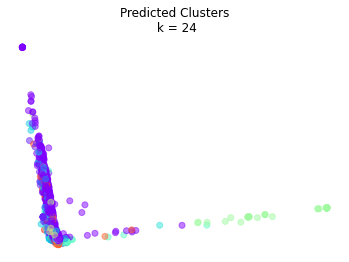

In [62]:
colors = list(plt.cm.rainbow(np.linspace(0,1, 24)))
colors_p = [colors[l] for l in reviewKM.labels_]
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(24))
plt.show()

This is a sampled 5000 reviews set from a corpus of over 4 million movie reviews. It's not surprising that we can hardly tell the differences of the 24 predicted categories from the figure. The sample size is small given the we set number of topics as 24 according the silhouette score. And the format of those reviews are short reviews, I think it makes the clustering process more difficult(or, unreliable is a more proper word). 

One implication could be that 24 categories might not be meaninglesss. On douban.com, movies are categorized into 22 genres. The clustering results may reveal distinct patterns of movies of different genres.

Another interesting thing abouth the results is that all the clusters are distributed on one of the directions that is perpendicular to each other. I think this indicates reviews can be largely divided into 2 categories. And it's partially determined by the format, partially driven by strightforward value judgements. I think these reviews can strongly correlated with ratings.

In [63]:
targetDF['kmeans_predictions'] = reviewKM.labels_
targetDF

,comment_time,content,douban_id,rating,cut_words,kmeans_predictions
0,2018-09-05 19:42:07,480p画质不高黑白y,5113101,2.0,480p 画质 不高 黑白 y,0
1,2019-07-09 14:52:07,毫无看点黑白画质一个男人孤独的心理情景历程疯疯癫癫没有任何恐怖的成分这应该是剧情片吧,5113101,1.0,毫无 看点 黑白 画质 一个 男人 孤独 的 心理 情景 历程 疯疯癫癫 没有 任何 恐怖 ...,9
2,2010-11-05 22:15:44,上吊那裡超好笑可惜最後報告近況的旁白大扣分,3718526,3.0,上吊 那裡 超 好笑 可惜 最後報 告近況 的 旁白 大 扣分,0
3,2010-06-20 02:12:50,上海国际电影节观摩片,3718526,NaN,上海 国际 电影节 观摩 片,0
4,2011-04-09 22:10:13,,3718526,NaN,,0
...,...,...,...,...,...,...
4995,2010-09-11 13:46:02,搞笑的励志电影,1309050,5.0,搞笑 的 励志 电影,4
4996,2010-10-23 13:19:17,美国所谓的人权,1309050,3.0,美国 所谓 的 人权,0
4997,2009-01-22 18:36:13,2009121在书房跟老公一起看的没看完但看过的部分很精彩期待,1309050,3.0,2009121 在 书房 跟 老公 一起 看 的 没 看 完 但 看过 的 部分 很 精彩 期待,6
4998,2011-10-19 12:00:27,我喜欢亚当桑德勒说橄榄球跟乒乓球差不多就是是蛋形的跟我的头一样lol另外我的Alexmaho...,1309050,3.0,我 喜欢 亚当 桑德勒 说 橄榄球 跟 乒乓球 差不多 就是 是 蛋形 的 跟 我 的 头 ...,15


# Hierarchical Clustering with Wald's Method

Next we approach a hierchical clustering method, which proposes nested clusters at any resolution (at the finest resolution, every document is its own cluster).

Here we must begin by calculating how similar the documents are to one another.

As a first pass, we take our matrix of word counts per document
`newsgroupsTFVects` and create a word occurrence matrix measuring how similar
the documents are to each other based on their number of shared words. (Note one could perform the converse operation, a document occurrence matrix measuring how similar  words are to each other based on their number of collocated documents).

In [ ]:
newsgroupsTFVects

In [ ]:
newsgroupsTFVects[:100].todense()

In [ ]:
newsgroupsCoocMat = newsgroupsTFVects * newsgroupsTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
newsgroupsCoocMat.setdiag(0)
#Another way of relating the texts is with their cosine similarity
#newsgroupsCosinMat1 = 1 - sklearn.metrics.pairwise.cosine_similarity(newsgroupsTFVects)
#But generally word occurrence is more accurate


Now we can compute a tree of nested clusters. Here we will only look at the first 50 texts of each class because drawing the dendrograms can be computationally intensive (and visually complex).

In [ ]:
selectIndices = []
indexToCat = []
for c in set(newsgroupsDF['category']):
    selectIndices += list(newsgroupsDF[newsgroupsDF['category'] == c].index)[:50]
    indexToCat += [c] * 50
    #.groupby('category').sum()

In [ ]:
subCoocMat = newsgroupsCoocMat[selectIndices,:][:,selectIndices]

In [ ]:
linkage_matrix = scipy.cluster.hierarchy.ward(subCoocMat.toarray())
linkage_matrix[:10]

Now we can visualize the tree

In [ ]:
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, get_leaves=True)

This plot may seem somewhat unwieldy. To make it easier to read, we can cut the tree after a number of branchings.

In [ ]:
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)

By default, the tree is colored to show the clusters based on their ['distance'](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram) from one another, but there are other ways of forming hierarchical clusters.

Another approach involves cutting the tree into `n` branches. We can do this with [`fcluster()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster). Lets break the tree into 4 clusters. When we do this with all of the data in the dataframe, as below, we can add those clusters back for detailed evaluation.

In [ ]:
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 4, 'maxclust')
hierarchicalClusters

We can use this *get clusters* like we did with k-means. What if we do the full data set?

In [ ]:
linkage_matrix_full = scipy.cluster.hierarchy.ward(newsgroupsCoocMat.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 4, 'maxclust')
print("For our complete clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], hierarchicalClusters_full)))

Not quite as good as k-means. Perhaps we've got too many words for Ward or maybe we shouldn't be using TFIDF as that compresses the space. Still, the hierarchical model places constraints on the clustering not present with k-means, which come at a cost. Finally, we can bring those cluster assignments back to the data frame for deeper investigation.

In [ ]:
newsgroupsDF['wald_predictions'] = hierarchicalClusters_full
newsgroupsDF

# Now let's do it with Senate press release data

We can also do hierarchical clustering with the Senate data. Let's start by creating the linkage matrix:

In [ ]:
exampleCoocMat = exampleTFVects * exampleTFVects.T
exampleCoocMat.setdiag(0)
examplelinkage_matrix = scipy.cluster.hierarchy.ward(exampleCoocMat[:100, :100].toarray())

And visualize the tree:

In [ ]:
ax = scipy.cluster.hierarchy.dendrogram(examplelinkage_matrix, p=5, truncate_mode='level')

Now let's do it with the entire data frame.

In [ ]:
example_linkage_matrix_full = scipy.cluster.hierarchy.ward(exampleCoocMat.toarray())
example_hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(example_linkage_matrix_full, 4, 'maxclust')

## <font color="red">*Exercise 2*</font>

<font color="red">Construct cells immediately below this that hierarchically cluster your documents using two approaches, and visualize them with a tree. Interrogate the recursive cluster contents in terms of both documents and closenesses. What does this nested cluster structure reveal about the organization of documents in your sampled corpora? Moreover, if they do worse than kmeans (as above), why do you think this is the case (hint: using metrics if you have ground truth or silhouette if you do not)? 

<font color="red">***Stretch***: Attempt using different distances into your clustering algorithms. (How) do they change the arrangement of clusters?

In [41]:
reviewCoocMat = reviewTFVects * reviewTFVects.T
reviewCoocMat.setdiag(0)

/Users/mao_shiba/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [43]:
review_linkage_matrix = scipy.cluster.hierarchy.ward(reviewCoocMat.toarray())

/Users/mao_shiba/opt/anaconda3/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


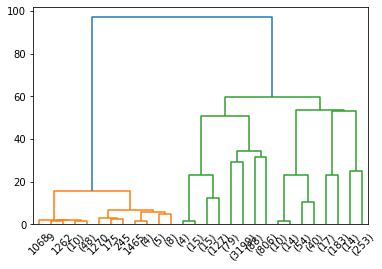

In [53]:
dendrogramDat = scipy.cluster.hierarchy.dendrogram(review_linkage_matrix, p=4, truncate_mode='level', get_leaves=True)

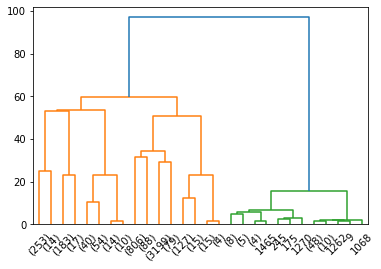

In [65]:
dendrogramDat = scipy.cluster.hierarchy.dendrogram(review_linkage_matrix, p=4, truncate_mode='level',distance_sort='descending', get_leaves=True)

In [54]:
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(review_linkage_matrix, 24, 'maxclust')
hierarchicalClusters

array([ 8, 12,  8, ..., 14, 22,  8], dtype=int32)

In [56]:
X = reviewTFVects.toarray()
sklearn.metrics.silhouette_score(X, hierarchicalClusters)

0.086283703639634

Hierarchical clustering also indicates that all the reviews can be largely divided into 2 categories. And one catetory has more reviews that the other's. It's silhouette score is slightly worse than k-means'. I think it's because most reviews are tring to tell you how good/bad the movie is, so hierarchical clustering is not a good choice. 

# Gensim

To do topic modeling we will also be using data from the [grimmer press releases corpus](ttps://github.com/lintool/GrimmerSenatePressReleases). To use the texts with gensim we need to create a `corpua` object, this takes a few steps. First we create a `Dictionary` that maps tokens to ids.

Here again we make use of `lucem_illud` functions. The source code of both of these is in [processing.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/processing.py).

In [ ]:
#Apply our functions
senReleasesTraining['tokenized_text'] = senReleasesTraining['text'].apply(lambda x: lucem_illud.word_tokenize(x))
senReleasesTraining['normalized_tokens'] = senReleasesTraining['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

In [ ]:
senReleasesTraining[::100]

In [69]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

# senReleasesTraining['reduced_tokens'] = senReleasesTraining['normalized_tokens'].apply(lambda x: dropMissing(x, senTFVectorizer.vocabulary_.keys()))

In [ ]:
dictionary = gensim.corpora.Dictionary(senReleasesTraining['reduced_tokens'])

Then for each of the texts we create a list of tuples containing each token and its count. We will only use the first half of our dataset for now and will save the remainder for testing.

In [ ]:
corpus = [dictionary.doc2bow(text) for text in senReleasesTraining['reduced_tokens']]

Then we serialize the corpus as a file and load it. This is an important step when the corpus is large.

In [ ]:
gensim.corpora.MmCorpus.serialize('senate.mm', corpus)
senmm = gensim.corpora.MmCorpus('senate.mm')

Now we have a correctly formatted corpus that we can use for topic modeling and induction.

In [ ]:
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

We can inspect the degree to which distinct texts load on different topics. Here is one of the texts from the training set:

In [ ]:
sen1Bow = dictionary.doc2bow(senReleasesTraining['reduced_tokens'][0])
sen1lda = senlda[sen1Bow]
print("The topics of the text: {}".format(senReleasesTraining['name'][0]))
print("are: {}".format(sen1lda))

We can now see which topics our model predicts press releases load on and make this into a `dataFrame` for later analysis.

In [ ]:
ldaDF = pandas.DataFrame({
        'name' : senReleasesTraining['name'],
        'topics' : [senlda[dictionary.doc2bow(l)] for l in senReleasesTraining['reduced_tokens']]
    })

This is a bit unwieldy so lets make each topic its own column:

In [ ]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF[1::100]

Now let's visualize this for several (e.g., 10) documents in the corpus. First we'll subset the data:

In [ ]:
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[:10][['name']]
ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
ldaDFV

First we can visualize as a stacked bar chart:

In [ ]:
N = 10
ind = np.arange(N)
K = senlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

We can also visualize as a heat map:

In [ ]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

We can also look at the top words from each topic to get a sense of the semantic (or syntactic) domain they represent. To look at the terms with the highest LDA weight in topic `1` we can do the following:

In [ ]:
senlda.show_topic(1)

And if we want to make a dataFrame:

In [ ]:
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

We can see that several of the topics have the same top words, but there are definitely differences. We can try and make the topics more distinct by changing the $\alpha$ and $\eta$ parameters of the model. $\alpha$ controls the sparsity of document-topic loadings, and $\eta$ controls the sparsity of topic-word loadings.

We can make a visualization of the distribution of words over any single topic.

In [ ]:
topic1_df = pandas.DataFrame(senlda.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

See how different $\eta$ values can change the shape of the distribution.

In [ ]:
senlda1 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.00001)
senlda2 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.9)

In [ ]:
topic11_df = pandas.DataFrame(senlda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(senlda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

### Heirarchial Dirichlet Process

We use LDA topic modeling above, but a similar alternative model you may run across is Hierarchical Dirichlet Processes, a nonparametric generalization of LDA. See, for example, [Teodoridis et al 2020](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3596233). One difference is how the researcher selects the number of topics.

In [ ]:
from gensim.models import HdpModel

In [ ]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)

In [ ]:
hdpmodel.print_topics()

Gensim sets the default number of topics as 150. This [stack overflow link](https://stackoverflow.com/questions/31543542/hierarchical-dirichlet-process-gensim-topic-number-independent-of-corpus-size) walks you through how to truncate these topics.

In [ ]:
hdptexts = hdpmodel[corpus]

In [ ]:
hdptexts[0]

This [HDP tutorial](https://towardsdatascience.com/dont-be-afraid-of-nonparametric-topic-models-part-2-python-e5666db347a) walks us through alternative HDP implementations outside of gensim.

## <font color="red">*Exercise 3*</font>

<font color="red">Construct cells immediately below this that topic model documents related to your anticipated final project. Interrogate and visually plot (e.g., as a bar graph?) the topic-word loadings and the document-topic loadings. What does this topic structure reveal about the distribution of contents across your documents? Systematically vary the $\alpha$, $\eta$, and topic number of the model for your text and describe in detail whether and how these changes led to distinctive outcomes, visible to you as analyst.  

<font color="red">**Stretch**: Cluster your documents, but instead of using words alone, use their topic loadings as an additional set of features. Do these topic loadings increase the apparent semantic coherence of your clusters?</font> 

In [70]:
reviews['reduced_tokens'] = reviews['cut_words'].apply(lambda x: x.split(' '))\
                                                .apply(lambda x: dropMissing(x, reviewTFVectorizer.vocabulary_.keys()))
reviews

,comment_time,content,douban_id,rating,cut_words,kmeans_predictions,reduced_tokens
0,2018-09-05 19:42:07,480p画质不高黑白y,5113101,2.0,480p 画质 不高 黑白 y,0,[]
1,2019-07-09 14:52:07,毫无看点黑白画质一个男人孤独的心理情景历程疯疯癫癫没有任何恐怖的成分这应该是剧情片吧,5113101,1.0,毫无 看点 黑白 画质 一个 男人 孤独 的 心理 情景 历程 疯疯癫癫 没有 任何 恐怖 ...,9,"[毫无, 看点, 一个, 男人, 孤独, 心理, 恐怖]"
2,2010-11-05 22:15:44,上吊那裡超好笑可惜最後報告近況的旁白大扣分,3718526,3.0,上吊 那裡 超 好笑 可惜 最後報 告近況 的 旁白 大 扣分,0,"[好笑, 可惜, 旁白]"
3,2010-06-20 02:12:50,上海国际电影节观摩片,3718526,NaN,上海 国际 电影节 观摩 片,0,[上海]
4,2011-04-09 22:10:13,,3718526,NaN,,0,[]
...,...,...,...,...,...,...,...
4995,2010-09-11 13:46:02,搞笑的励志电影,1309050,5.0,搞笑 的 励志 电影,4,"[搞笑, 励志, 电影]"
4996,2010-10-23 13:19:17,美国所谓的人权,1309050,3.0,美国 所谓 的 人权,0,[美国]
4997,2009-01-22 18:36:13,2009121在书房跟老公一起看的没看完但看过的部分很精彩期待,1309050,3.0,2009121 在 书房 跟 老公 一起 看 的 没 看 完 但 看过 的 部分 很 精彩 期待,6,"[看过, 精彩, 期待]"
4998,2011-10-19 12:00:27,我喜欢亚当桑德勒说橄榄球跟乒乓球差不多就是是蛋形的跟我的头一样lol另外我的Alexmaho...,1309050,3.0,我 喜欢 亚当 桑德勒 说 橄榄球 跟 乒乓球 差不多 就是 是 蛋形 的 跟 我 的 头 ...,15,"[喜欢, 亚当, 桑德勒, 橄榄球, 差不多, 太帅, 年轻, 爱上]"


In [102]:
empty_lst = []
for index, row in reviews.iterrows():
    if row['reduced_tokens'] == []:
        empty_lst.append(index)

reviews.drop(empty_lst, axis=0, inplace=True)

In [103]:
review_dictionary = gensim.corpora.Dictionary(reviews['reduced_tokens'])

In [104]:
review_corpus = [review_dictionary.doc2bow(text) for text in reviews['reduced_tokens']]

In [105]:
gensim.corpora.MmCorpus.serialize('review.mm', review_corpus)
review_mm = gensim.corpora.MmCorpus('review.mm')

In [106]:
review_lda = gensim.models.ldamodel.LdaModel(corpus=review_mm, 
                                             id2word=review_dictionary, 
                                             num_topics=10, 
                                             alpha=0.1, 
                                             eta=0.01)

In [115]:
ldaDF = pandas.DataFrame({
        'content' : reviews['content'],
        'topics' : [review_lda[review_dictionary.doc2bow(l)] for l in reviews['reduced_tokens']]
    })
ldaDF

,content,topics
1,毫无看点黑白画质一个男人孤独的心理情景历程疯疯癫癫没有任何恐怖的成分这应该是剧情片吧,"[(0, 0.012511339), (1, 0.01251113), (2, 0.0125..."
2,上吊那裡超好笑可惜最後報告近況的旁白大扣分,"[(0, 0.7748718), (1, 0.025009722), (2, 0.02501..."
3,上海国际电影节观摩片,"[(0, 0.050006583), (1, 0.050011717), (2, 0.050..."
5,那些不同人们的生活状态真实且残酷描述这类人生活的片子多了有点不太敢去德国了生怕那里的人心底里...,"[(2, 0.95498073)]"
6,生活用最残酷的方式让你笑笑得哭出来,"[(0, 0.025010336), (1, 0.025001336), (2, 0.774..."
...,...,...
4995,搞笑的励志电影,"[(0, 0.77486277), (1, 0.025003122), (2, 0.0250..."
4996,美国所谓的人权,"[(0, 0.050000317), (1, 0.050000317), (2, 0.050..."
4997,2009121在书房跟老公一起看的没看完但看过的部分很精彩期待,"[(0, 0.025000677), (1, 0.02500243), (2, 0.7749..."
4998,我喜欢亚当桑德勒说橄榄球跟乒乓球差不多就是是蛋形的跟我的头一样lol另外我的Alexmaho...,"[(0, 0.016667875), (1, 0.19055559), (2, 0.0166..."


In [118]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(review_lda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(review_lda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF[1::100]

,content,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
2,上吊那裡超好笑可惜最後報告近況的旁白大扣分,"[(0, 0.7748718), (1, 0.025009722), (2, 0.02501...",0.774872,0.025010,0.025011,0.025010,0.025011,0.025012,0.025027,0.025011,0.025024,0.025012
129,徐海乔的演技很好人设也很苏对女主比较崩溃又作又矫情电影立意还好就是剧情太简单,"[(4, 0.72543454), (8, 0.20179272)]",0.000000,0.000000,0.000000,0.000000,0.725435,0.000000,0.000000,0.000000,0.201793,0.000000
248,原来主妇还有这么青葱的岁月呀哈哈哈小姐这是你掉的熊吗啊哈哈哈,"[(0, 0.016673487), (1, 0.01667151), (2, 0.0166...",0.016673,0.016672,0.016671,0.016671,0.016672,0.849955,0.016671,0.016671,0.016671,0.016672
355,那是一种伤在血液里流动,"[(0, 0.05000922), (1, 0.05000255), (2, 0.05000...",0.050009,0.050003,0.050000,0.050010,0.050001,0.050001,0.050000,0.549970,0.050003,0.050002
473,小成本的好電影,"[(0, 0.05000306), (1, 0.050003435), (2, 0.0500...",0.050003,0.050003,0.050005,0.050003,0.050003,0.050012,0.050003,0.050003,0.050003,0.549961
592,如果你认识一对性欲非常旺盛的夫妇他们可能只是想要个孩子虽然是近来快被国内电视剧玩烂的题材但还...,"[(0, 0.13448688), (1, 0.011114266), (2, 0.0111...",0.134487,0.011114,0.011117,0.263763,0.011115,0.011118,0.011116,0.243479,0.291570,0.011122
725,至今看了三个版本竟然没有一个版本贴原著的,"[(0, 0.012505284), (1, 0.012503927), (2, 0.012...",0.012505,0.012504,0.012505,0.012502,0.564786,0.012503,0.012503,0.012502,0.012503,0.335187
845,打小就喜欢看这种片难怪现在喜欢看基情片,"[(0, 0.03333409), (1, 0.0333338), (2, 0.033335...",0.033334,0.033334,0.033336,0.699991,0.033335,0.033334,0.033334,0.033334,0.033334,0.033334
955,西班牙江姐,"[(0, 0.050003838), (1, 0.050010953), (2, 0.050...",0.050004,0.050011,0.050004,0.050004,0.050004,0.050005,0.050004,0.549957,0.050004,0.050004
1073,笑死我了哈哈哈哈哈哈哈哈哈,"[(0, 0.02500031), (1, 0.02500035), (2, 0.02500...",0.025000,0.025000,0.025000,0.025000,0.025000,0.774997,0.025000,0.025001,0.025000,0.025000


In [131]:
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[:10].index
ldaDFVis = ldaDFV.values
ldaDFVisNo = ldaDFVisN.values
ldaDFVisNo = ['Review No. {}'.format(i) for i in ldaDFVisNo]

/var/folders/cl/g60_skzn66v711f0ctx1nw_w0000gn/T/ipykernel_2391/253789795.py:14: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  plt.colorbar(cmap='Reds')


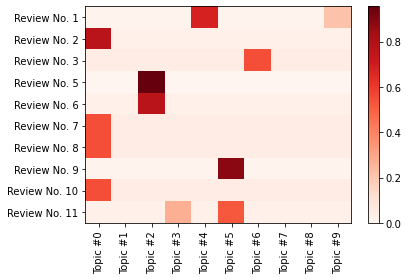

In [132]:
K = review_lda.num_topics
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.pcolor(ldaDFVis, norm=None, cmap='Reds')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5,ldaDFVisNo);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Reds')
plt.tight_layout()  # fixes margins
plt.show()

In [133]:
topicsDict = {}
for topicNum in range(review_lda.num_topics):
    topicWords = [w for w, p in review_lda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,一个,有趣,老爷,喜欢,电影,电影,电影,日本,一个,男人
1,镜头,摄影,片子,电影,一个,故事,爱情,导演,好看,剧情
2,搞笑,青春,黑暗,感觉,镜头,一部,婚姻,故事,故事,喜剧
3,恋爱,刻意,精彩,表达,可爱,选择,美国,一种,发生,不到
4,算是,一部,开心,这部,年轻,制片,女人,15,角色,老版
5,导演,导演,喜欢,好像,女孩,一个,暴力,不错,导演,江湖
6,两个,片子,励志,困境,婚礼,小姐,名字,年轻,韩国,孩子
7,社会,形象,生活,影片,青春片,导演,一场,只能,演员,角色
8,竟然,调度,工作,观众,感觉,真的,期待,一个,夫妻,配乐
9,兄弟,克制,剧情,风格,真实,仿佛,乏味,希望,青春,神经


In [136]:
review_lda = gensim.models.ldamodel.LdaModel(corpus=review_mm, 
                                             id2word=review_dictionary, 
                                             num_topics=6, 
                                             alpha=0.1, 
                                             eta=0.01)
ldaDF = pandas.DataFrame({
        'content' : reviews['content'],
        'topics' : [review_lda[review_dictionary.doc2bow(l)] for l in reviews['reduced_tokens']]
    })

#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(review_lda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(review_lda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF[1:10]

,content,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5
2,上吊那裡超好笑可惜最後報告近況的旁白大扣分,"[(0, 0.027796784), (1, 0.8609968), (2, 0.02779...",0.027797,0.860997,0.027797,0.027795,0.027814,0.027801
3,上海国际电影节观摩片,"[(0, 0.0625147), (1, 0.0625147), (2, 0.0625147...",0.062515,0.062515,0.062515,0.062515,0.062515,0.687427
5,那些不同人们的生活状态真实且残酷描述这类人生活的片子多了有点不太敢去德国了生怕那里的人心底里...,"[(2, 0.117083274), (5, 0.86250025)]",0.000000,0.000000,0.117083,0.000000,0.000000,0.862500
6,生活用最残酷的方式让你笑笑得哭出来,"[(0, 0.02778144), (1, 0.027781915), (2, 0.0277...",0.027781,0.027782,0.027787,0.508974,0.027784,0.379892
7,连这个竟然都看了,"[(0, 0.062521815), (1, 0.6874453), (2, 0.06252...",0.062522,0.687445,0.062526,0.062502,0.062501,0.062504
8,我不知道那时候为什么看了这么多香港口水片,"[(0, 0.06252114), (1, 0.06252154), (2, 0.06253...",0.062521,0.062522,0.062535,0.062521,0.062521,0.687380
9,小姐你的熊掉了小姐你的熊掉了小姐你的熊掉了我发现我建条目上瘾了,"[(0, 0.9341956), (1, 0.0131615), (2, 0.0131592...",0.934196,0.013161,0.013159,0.013160,0.013163,0.013161
10,全职主妇侦探不是强盗,"[(0, 0.06253655), (1, 0.06253651), (2, 0.06255...",0.062537,0.062537,0.062551,0.687304,0.062536,0.062536
11,哈哈哈哈哈哈哈师父果然威武,"[(0, 0.027817165), (1, 0.3038627), (2, 0.30237...",0.027817,0.303863,0.302377,0.027813,0.027812,0.310318


In [137]:
topicsDict = {}
for topicNum in range(review_lda.num_topics):
    topicWords = [w for w, p in review_lda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5
0,喜欢,一部,喜剧,一个,导演,电影
1,一个,片子,婚姻,剧情,感觉,喜欢
2,一部,开心,男人,电影,年轻,镜头
3,电影,真的,结局,感觉,选择,故事
4,青春,一个,爱情,喜欢,故事,日本
5,励志,电影,搞笑,睡着,一种,这部
6,角色,乏味,兄弟,恋爱,喜欢,表达
7,有趣,故事,生活,婚礼,老爷,一个
8,影片,期待,悲剧,浪费,一个,感觉
9,一段,发生,记得,方式,有趣,黑暗


In [138]:
review_lda = gensim.models.ldamodel.LdaModel(corpus=review_mm, 
                                             id2word=review_dictionary, 
                                             num_topics=6, 
                                             alpha=0.1, 
                                             eta=0.1)
ldaDF = pandas.DataFrame({
        'content' : reviews['content'],
        'topics' : [review_lda[review_dictionary.doc2bow(l)] for l in reviews['reduced_tokens']]
    })

#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(review_lda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(review_lda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF[1:10]

,content,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5
2,上吊那裡超好笑可惜最後報告近況的旁白大扣分,"[(0, 0.027781315), (1, 0.027781803), (2, 0.027...",0.027781,0.027782,0.027782,0.027783,0.027782,0.861090
3,上海国际电影节观摩片,"[(0, 0.062524945), (1, 0.062524945), (2, 0.687...",0.062525,0.062525,0.687351,0.062532,0.062525,0.062542
5,那些不同人们的生活状态真实且残酷描述这类人生活的片子多了有点不太敢去德国了生怕那里的人心底里...,"[(3, 0.2029519), (4, 0.7766278)]",0.000000,0.000000,0.000000,0.202952,0.776628,0.000000
6,生活用最残酷的方式让你笑笑得哭出来,"[(0, 0.027789395), (1, 0.027787425), (2, 0.440...",0.027789,0.027787,0.440833,0.448016,0.027785,0.027788
7,连这个竟然都看了,"[(0, 0.06250188), (1, 0.06250266), (2, 0.68747...",0.062502,0.062503,0.687475,0.062501,0.062502,0.062518
8,我不知道那时候为什么看了这么多香港口水片,"[(0, 0.06253779), (1, 0.06252434), (2, 0.06251...",0.062538,0.062524,0.062519,0.062519,0.062519,0.687380
9,小姐你的熊掉了小姐你的熊掉了小姐你的熊掉了我发现我建条目上瘾了,"[(0, 0.9342012), (1, 0.013159618), (2, 0.01315...",0.934201,0.013160,0.013160,0.013160,0.013160,0.013159
10,全职主妇侦探不是强盗,"[(0, 0.06254208), (1, 0.06255752), (2, 0.06254...",0.062542,0.062558,0.062542,0.062542,0.687259,0.062558
11,哈哈哈哈哈哈哈师父果然威武,"[(0, 0.0278009), (1, 0.86099255), (2, 0.027802...",0.027801,0.860993,0.027802,0.027802,0.027800,0.027803


In [139]:
topicsDict = {}
for topicNum in range(review_lda.num_topics):
    topicWords = [w for w, p in review_lda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5
0,日本,一个,电影,电影,喜欢,电影
1,田中,喜欢,导演,感觉,电影,导演
2,老爷,镜头,一部,一个,困境,故事
3,一个,婚姻,不错,故事,男人,喜剧
4,北野武,爱情,一个,生活,励志,表达
5,发生,开心,这部,镜头,搞笑,很多
6,妈妈,美国,青春,一种,喜剧,印象
7,阿凡提,阿凡提,影片,人物,亚当,时刻
8,工作,选择,喜欢,剧情,一场,15
9,期待,恋爱,片子,郑佩佩,镜头,一个


Topic modeling tells us more details about those reviews. At first I used 10 topics to fit the model, many top weighted words overlap. Then I ruduced the number to 6. We can find different feelings and genres in different topics. Changing $\eta$ from 0.01 to 0.1 makes the topics more confusing. Many names occur in topics. I think it's beacuse all reviews are short so they have their unique words. Hence a higher $\eta$ maybe a misplace.
Combining with clustering results, topic modelling did tell us more details about those reviews. However, this a rudimentary exploration. Some improvements can be made. For example, 一个（a/one）,电影（movie) appeared in many topics. We could add these words to stop words list first. This is a randomed sample. Most reviews are from less popular movies. Maybe sampling reviews from a few popular movies is a better choice. We can find more interesting patterns.

## Extending Topic Models within broader research pipelines

Topic models can be the base of more complex analysis. One good example is the paper - Individuals, institutions, and innovation in the debates of the French Revolution (https://www.pnas.org/content/115/18/4607), where they use topic models to find similarities and differences between the topics of different individuals. Let us revisit this idea using the Soap opera database. Who innovates and influences the most within the Soap?

The next few lines of code follows the same process as last weeks notebook. Please visit the old notebook to read descriptions of the code if you have forgotten what it does. `lucem_illud.loadDavies` can be found in [loaders.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/loaders.py).

In [ ]:
corpora_address = "/Users/bhargavvader/Downloads/Academics_Tech/corpora/SOAP"

In [ ]:
soap_texts = lucem_illud.loadDavies(corpora_address, num_files=2000)

In [ ]:
import zipfile
import pandas as pd

In [ ]:
zfile = zipfile.ZipFile(corpora_address + "/soap_sources.zip")
source = []

In [ ]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [ ]:
soap_dict = {}

In [ ]:
for soap in source[3:]:
    try:
        textID, year, show, url = soap.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    if show.strip() not in soap_dict:
        soap_dict[show.strip()] = []
    if show.strip() in soap_dict:
        try:
            soap_dict[show.strip()].append(soap_texts[textID.strip()])
        except KeyError:
            continue

In [ ]:
soap_dict.keys()

In [ ]:
soap_df = pd.DataFrame(columns=["Soap Name", "Tokenized Texts"])

In [ ]:
i = 0

In [ ]:
for soap in soap_dict:
    # since there were multiple lists
    print(soap)
    full_script = []
    for part in soap_dict[soap]:
        full_script = full_script + part
    soap_df.loc[i] = [soap, full_script]
    i += 1

In [ ]:
soap_df

Checking to see which index I should use. In my example it is the last one, so I choose my index as 9. It might be different for you!

In [ ]:
dool = soap_df['Tokenized Texts'][9]

In [ ]:
' '.join(dool[0:1500])

In [ ]:
characters = {}
for token in dool:
    if token[0] == '@':
        # all characters or actions start with @, so we add that to character
        if token[2:] not in characters:
            characters[token[2:]] = 0
        if token[2:] in characters:
            characters[token[2:]] += 1

In [ ]:
import networkx as nx

In [ ]:
actor_network = nx.Graph()

In [ ]:
for character in characters:
    if characters[character] > 2000:
        actor_network.add_node(character, lines_spoken= characters[character], words=[])

In [ ]:
i = 0

In [ ]:
all_texts = []

In [ ]:
for token in dool:
    i += 1
    if i > len(dool):
        break
    if token[0] == "@":
        if token[2:] in actor_network.nodes():
            j = i
            for token_ in dool[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network.nodes():
                        if (token[2:], token_[2:]) not in actor_network.edges():
                            actor_network.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network.edges():
                            actor_network.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network.nodes[token[2:]]['words'].append(dool[i:j])
            all_texts.append(lucem_illud.normalizeTokens(dool[i:j]))

In [ ]:
nx.draw(actor_network, with_labels=True, font_weight='bold')

Ok - so we have our graph now. Let us create a topic model with all the texts spoken by the characters, see what's being spoken about, and construct topic distributions for each character. What does our all_texts corpus look like?

In [ ]:
all_texts[0:10]

In [ ]:
dictionary = gensim.corpora.Dictionary(all_texts)

In [ ]:
corpus = [dictionary.doc2bow(text) for text in all_texts]

In [ ]:
gensim.corpora.MmCorpus.serialize('dool.mm', corpus)
doolcorpus = gensim.corpora.MmCorpus('dool.mm')

In [ ]:
doollda = gensim.models.ldamodel.LdaModel(corpus=doolcorpus, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [ ]:
doollda.show_topics()

Are your topics interpretable/interesting? Sometimes they require a good deal of fine tuning and parameter choosing to get it to work in a nice way. Check out the gensim ldamodel documentation page and see what parameters you can play around with and try the model again!

In [ ]:
for actor in actor_network.nodes():
    actor_all_words = []
    for sent in actor_network.nodes[actor]['words']:
        for word in sent:
            actor_all_words += word
    actor_network.nodes[actor]['topic_distribution'] = doollda[dictionary.doc2bow(lucem_illud.normalizeTokens(actor_all_words))]

We now have topic distributions for each character. Let us have a brief look at what the characters are talking about. 

In [ ]:
for actor in actor_network.nodes():
    print(actor, actor_network.nodes[actor]['topic_distribution'])

Quickly eye-balling these distributions suggest that the model itself could be tuned better - all the topics are loaded more or less equally. 

In the paper I linked to earlier, they found similarities or differences using the KL divergence - this is a topic we've dealt with before. Let us plot a heatmap with these values.

In [ ]:
from gensim.matutils import kullback_leibler

In [ ]:
def convert_to_prob(bow):
    ps = []
    for topic_no, topic_prob in bow:
        ps.append(topic_prob)
    return ps

In [ ]:
L = []
for actor_1 in actor_network.nodes():
    p = actor_network.nodes[actor_1]['topic_distribution'] 
    p = convert_to_prob(p)
    l = []
    for actor_2 in actor_network.nodes():
        q = actor_network.nodes[actor_2]['topic_distribution'] 
        q = convert_to_prob(q)
        l.append(kullback_leibler(p, q))
    L.append(l)
M = np.array(L)

In [ ]:
fig = plt.figure()
div = pandas.DataFrame(M, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

This is one example of how we can use topic models to analyse a network - what other data exploration can you come up with?  Maybe see what are the themes surrounding the top topics for each of the actors? You now have the infrastructure to explore the network and the topics. Gensim has a great set of Jupyter Notebooks which illustrate their methods and functions - https://github.com/RaRe-Technologies/gensim/tree/develop/docs/notebooks. The Auto Examples page also has a good variety of examples - https://radimrehurek.com/gensim/auto_examples/. 


### Dynamic Topic Modelling

Dynamic Topic Modelling is a time based topic model method introduced by David Blei and John Lafferty. It allows one to see topics evolve over a time annotated corpus. I would recommend first viewing the Dynamic Topic Model tutorial on Gensim (https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/ldaseqmodel.ipynb) to understand what exactly it's about. 

(An acknowledgement - Bhargav (the author of most of this class's code) wrote the code for Gensim's Dynamic Topic Models back in 2016 as a Google Summer of Code student, and they're still using it as are thousands of others!)

To demonstrate it on a time based corpus, we will create a corpus from COHA.

In [ ]:
corpora_address = "/Users/bhargavvader/Downloads/Academics_Tech/corpora/COHA"

In [ ]:
coha_texts = lucem_illud.loadDavies(corpora_address, return_raw=True)

In [ ]:
list(coha_texts.keys())[0:5]

We'd have to approach this differently: note that while extracting the corpus we returned the raw texts, and the dictionary keys already contain some useful information: the year published, and the genre. neat! We can now create some corpora, organised by year and by genre.

In [ ]:
coha_genres = {}
coha_years = {}

In [ ]:
for article in coha_texts:
    genre, year, id_ = article.split("_")
    if genre not in coha_genres:
        coha_genres[genre] = []
    if genre in coha_genres:
        coha_genres[genre].append(coha_texts[article])
    
    if year not in coha_years:
        coha_years[year] = []
    if year in coha_years:
        coha_years[year].append(coha_texts[article])

In [ ]:
coha_genres.keys()

In [ ]:
coha_years.keys()

That's neat: we have 4 genres and 200 years. We have to now decide how many time slices we want. Let us see how the corpus is distributed.

If you went through the tutorial, you would notice how we would need to arrange the corpora year wise.
We also have to arrange the number of topics per year.

In [5]:
import collections

In [ ]:
years = []
year_lens = []

In [ ]:
for year_info in collections.OrderedDict(sorted(coha_years.items())):
    years.append(year_info)
    year_lens.append(len((coha_years[year_info])))

In [ ]:
years[0], years[-1]

In [6]:
import matplotlib.pyplot as plt
plt.plot(years, year_lens)

The X axis isn't legible, but you can get the point: there are far less articles in the beginning, and then it grows. Maybe in our 5 time slices, we do: 1810-1880, 1881-1913, 1914-1950, 1950-1990, 1990-2009?
I use some historical intuition to use these time periods, you are encouraged to try your different time slices (for e.g, 20 10 year periods, 10 20 year periods, by total number of papers, etc)

In [ ]:
all_texts_coha = []
docs_per_timeslice = [0, 0, 0, 0, 0]
i = 0

In [ ]:
for year_info in collections.OrderedDict(sorted(coha_years.items())):
    large_files = 0
    for article in coha_years[year_info]:
        try:
            if len(article[2]) < 1500000:
                all_texts_coha.append(lucem_illud.normalizeTokens(article[2].decode("utf-8")))
            if len(article[2]) >= 1500000:
                large_files += 1
        except IndexError:
            continue
    # these numbers are the number of years in the 
    if i < 70:
        docs_per_year[0] += len(coha_years[year_info]) - large_files
    if i >= 70 and i < 103:
        docs_per_year[1] += len(coha_years[year_info]) - large_files
    if i >= 103 and i < 140:
        docs_per_year[2] += len(coha_years[year_info]) - large_files
    if i >= 140 and i < 180:
        docs_per_year[3] += len(coha_years[year_info]) - large_files
    if i >= 180:
        docs_per_year[4] += len(coha_years[year_info]) - large_files
    i += 1

#### Smaller Corpora

The original size of the corpus is wayyy too big for our laptops. Let us demo this with a smaller size. You are welcome to try different sizes until you get the size you would like.
I am using a 100 documents per time slice for this example.

In [42]:
def choose_n(corpus, time_slices, nums=100):
    new_corpus = corpus[0:nums]
    for time_slice in time_slices[:-1]:
        new_corpus = new_corpus + corpus[time_slice:time_slice+nums]
    return new_corpus

Now, COHA also has some really large files, full books and the like: we're going to now split up really large files such that each of the documents are only 1000 tokens long. This function will return a split up document and the number of files it has been split into, so we can accordingly adjust the documents per time slice, which is important for Dynamic Topic Modelling to work.

In [ ]:
def split_up(document, doc_size=1000):
    new_docs = [document[i:i + doc_size] for i in range(0, len(document), doc_size)]
    return(new_docs, len(new_docs))

In [ ]:
small_corpus = choose_n(all_texts_coha, docs_per_year, nums=100)

In [ ]:
final_corpus= []

In [ ]:
docs_per_time_slice = [0, 0, 0, 0, 0]

I now use the split method to create my final corpus. Note that I hardcode values for the time slice to figure out the number of documets per time slice. Now I have a representative number of documents in each time slice. 

In [ ]:
for i, article in enumerate(small_corpus):
    # identify time slice based on article number 
    if i < 100:
        time = 0
    if i > 100 and i <= 200:
        time = 1
    if i > 200 and i <= 300:
        time = 2
    if i > 300 and i <= 400:
        time = 3
    if i > 400 and i <= 500:
        time = 4
        
    if len(article) > 1000:
        split_docs, no_docs = split_up(article)
        for doc in split_docs:
            final_corpus.append(doc)
        docs_per_time_slice[time] += no_docs
    else:
        final_corpus.append(article)
        docs_per_time_slice[time] += 1
    # just a check if the counts are correctly added
    if np.sum(docs_per_time_slice) != len(final_corpus):
        print(np.sum(docs_per_time_slice), len(final_corpus))

In [ ]:
dictionary = gensim.corpora.Dictionary(final_corpus)

In [ ]:
corpus = [dictionary.doc2bow(text) for text in final_corpus]

In [ ]:
gensim.corpora.MmCorpus.serialize('coha.mm', corpus)
cohacorpus = gensim.corpora.MmCorpus('coha.mm')

In [7]:
from gensim.models import ldaseqmodel

In [ ]:
ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=docs_per_time_slice, num_topics=4)

In [ ]:
ldaseq.print_topics(time=0)[1]

In [ ]:
ldaseq.print_topics(time=4)[1]

What can you see from the analysis? I encourage you to explore the tutorial and see what else you can do with this dataset. In the above model I can see how the topic related to state evolves slowly, with the word president not previously there coming into the topic. I will now save this model and also upload it on GitHub so that you can see how it works. Note that the Dynamic Topic Model is a very time consuming algorithm: you might want to start a run overnight if you intend on using it in your analysis.

In [ ]:
ldaseq.save("ldaseqmodel")

In [ ]:
loaded_model = ldaseqmodel.LdaSeqModel.load("ldaseqmodel")

For future research, you can also consider the Structural Topic Model (STM), which can integrate any covariates (e.g., time, author, document length) into your topic model. Unfortunately there is not yet an implementation of this in Python, but there is a wonderful [R package](https://www.structuraltopicmodel.com/) authored by Molly Roberts, Brandon Stewart, and Dustin Tingley.

Here are plate diagrams of LDA and STM, which may help you visualize the way STM adds covariates to the "left" and "right" of the standard LDA model.

<img src="https://raw.githubusercontent.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/main/week-3/img/lda_stm_plate_diagrams.jpg" alt="https://raw.githubusercontent.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/main/week-3/img/lda_stm_plate_diagrams.jpg" style="width:500px">



## <font color="red">*Exercise 4*</font>

<font color="red">Construct cells immediately below this that use dynamic topic models on datasets relevant to your final project. You can also extend the analysis of the COHA or Soap datasets, if relevant to the comparison of data for your projects. (You could possibly use coha_genres dictionary to conduct analysis on topic evolution for a particular genre? What themes do you see evolving throughout these corpora?)

In this exercise, I selected around 500 reviews per year to build a dynamic topic model.

In [167]:
reviews_all = pandas.read_csv('/Users/mao_shiba/Downloads/moviedata-10m/moviedata-10m/comments.csv')
reviews_all = reviews_all.loc[:, ['COMMENT_TIME','CONTENT', 'MOVIE_ID']]

In [168]:
reviews_all['COMMENT_TIME'] = pandas.to_datetime(reviews_all['COMMENT_TIME'])
reviews_all = reviews_all.sort_values(by = 'COMMENT_TIME')
reviews_all.tail()

,COMMENT_TIME,CONTENT,MOVIE_ID
4427687,2019-09-07 15:57:07,就很尬，很无聊，笑点好无语，朱亚文为什么要接这样的片子啊………,27063867
4427686,2019-09-07 15:58:03,吃了感冒药去看的，困上加困。朱亚文是想通过这部作品来拓宽戏路吗？,27063867
4427685,2019-09-07 15:58:51,有些地方还是很好笑的，奔着两位主演去看，他们也确实有范儿，倒数第二场戏，两人穿礼服去办公室真...,27063867
4418159,2019-09-07 15:59:42,OMG,1292226
4424115,2019-09-07 16:00:15,舒缓的节奏与童书相称,1900121


In [169]:
reviews_all = reviews_all.set_index('COMMENT_TIME')

In [170]:
reviews_2006_2019 = reviews_all['1/1/2006':'12/31/2019']
time_slice = reviews_2006_2019.groupby(reviews_2006_2019.index.year).count()
time_slice = time_slice['CONTENT'].to_list()
for i in range(len(time_slice)):
    print("Reviews in Time Slice {}:".format(i), time_slice[i])

Reviews in Time Slice 0: 13596
Reviews in Time Slice 1: 34985
Reviews in Time Slice 2: 92790
Reviews in Time Slice 3: 142998
Reviews in Time Slice 4: 261817
Reviews in Time Slice 5: 355514
Reviews in Time Slice 6: 377019
Reviews in Time Slice 7: 312148
Reviews in Time Slice 8: 270202
Reviews in Time Slice 9: 268842
Reviews in Time Slice 10: 344790
Reviews in Time Slice 11: 453416
Reviews in Time Slice 12: 563923
Reviews in Time Slice 13: 934830


In [171]:
def choose_n_from_df(corpus, time_slices, nums=500):
    new_corpus = corpus.iloc[0:nums]
    start = time_slices[0]
    for time_slice in time_slices[1:]:
        new_corpus = pandas.concat([new_corpus, corpus.iloc[start:start+nums]], axis=0)
        start += time_slice
    return new_corpus

In [172]:
reviews_2006_2019.reset_index()

,COMMENT_TIME,CONTENT,MOVIE_ID
0,2006-01-01 00:08:26,没有一个女性角色出现，一样喘不过气。,1293770
1,2006-01-01 00:23:17,罗拉把我跑晕掉了，那是我辈梦想了许许多多年的存盘/取出大法。原来电影可以这么拍哦。蒙太奇可以...,1292275
2,2006-01-01 01:59:42,这样子的心计，到底是环境的逼迫，还是本性的爆发？,1307679
3,2006-01-01 02:04:01,我从没想到过这个梦会有如此多的缺憾，但也没想到他又会有如此完满的结局，I LOVE THIS...,1293179
4,2006-01-01 06:29:26,讲故事都讲不来，情节太荒谬了；10年12月，在CCTV6又看了一些，觉得表演也太做作，故事还...,1419969
...,...,...,...
4426867,2019-09-07 15:57:07,就很尬，很无聊，笑点好无语，朱亚文为什么要接这样的片子啊………,27063867
4426868,2019-09-07 15:58:03,吃了感冒药去看的，困上加困。朱亚文是想通过这部作品来拓宽戏路吗？,27063867
4426869,2019-09-07 15:58:51,有些地方还是很好笑的，奔着两位主演去看，他们也确实有范儿，倒数第二场戏，两人穿礼服去办公室真...,27063867
4426870,2019-09-07 15:59:42,OMG,1292226


In [174]:
small_reviews = choose_n_from_df(reviews_2006_2019, time_slice, nums=500)
small_reviews

,CONTENT,MOVIE_ID
COMMENT_TIME,,
2006-01-01 00:08:26,没有一个女性角色出现，一样喘不过气。,1293770
2006-01-01 00:23:17,罗拉把我跑晕掉了，那是我辈梦想了许许多多年的存盘/取出大法。原来电影可以这么拍哦。蒙太奇可以...,1292275
2006-01-01 01:59:42,这样子的心计，到底是环境的逼迫，还是本性的爆发？,1307679
2006-01-01 02:04:01,我从没想到过这个梦会有如此多的缺憾，但也没想到他又会有如此完满的结局，I LOVE THIS...,1293179
2006-01-01 06:29:26,讲故事都讲不来，情节太荒谬了；10年12月，在CCTV6又看了一些，觉得表演也太做作，故事还...,1419969
...,...,...
2019-01-01 09:39:22,1111,26990112
2019-01-01 09:40:00,1111,27185049
2019-01-01 09:40:42,111,30406175


In [175]:
# source: https://github.com/goto456/stopwords/blob/master/baidu_stopwords.txt
stop_words = open("/Users/mao_shiba/Downloads/stopwords-master/baidu_stopwords.txt", 'r', encoding='utf-8').read()
stop_words_lst = stop_words.split('\n') + ['电影', '一部', '一个', '很' ]


In [176]:
small_reviews['regex_content'] = small_reviews['CONTENT'].replace('[^\u4e00-\u9fa50-9]+', ' ', regex=True)
cut_words = lambda x: [word for word in jieba.lcut(x) if word not in stop_words_lst]
small_reviews['cut_words'] = small_reviews['regex_content'].apply(cut_words)
small_reviews

,CONTENT,MOVIE_ID,regex_content,cut_words
COMMENT_TIME,,,,
2006-01-01 00:08:26,没有一个女性角色出现，一样喘不过气。,1293770,没有一个女性角色出现 一样喘不过气,"[女性, 角色, 喘, 气]"
2006-01-01 00:23:17,罗拉把我跑晕掉了，那是我辈梦想了许许多多年的存盘/取出大法。原来电影可以这么拍哦。蒙太奇可以...,1292275,罗拉把我跑晕掉了 那是我辈梦想了许许多多年的存盘 取出大法 原来电影可以这么拍哦 蒙太奇可以...,"[罗拉, 跑, 晕, 掉, 我辈, 梦想, 许许多多, 年, 存盘, 取出, 大法, 拍, ..."
2006-01-01 01:59:42,这样子的心计，到底是环境的逼迫，还是本性的爆发？,1307679,这样子的心计 到底是环境的逼迫 还是本性的爆发,"[样子, 心计, 到底, 环境, 逼迫, 本性, 爆发]"
2006-01-01 02:04:01,我从没想到过这个梦会有如此多的缺憾，但也没想到他又会有如此完满的结局，I LOVE THIS...,1293179,我从没想到过这个梦会有如此多的缺憾 但也没想到他又会有如此完满的结局,"[没想到, 梦会, 缺憾, 没想到, 又会有, 完满, 结局]"
2006-01-01 06:29:26,讲故事都讲不来，情节太荒谬了；10年12月，在CCTV6又看了一些，觉得表演也太做作，故事还...,1419969,讲故事都讲不来 情节太荒谬了 10年12月 在 6又看了一些 觉得表演也太做作 故事还是莫名其妙,"[讲故事, 都, 讲, 不来, 情节, 太, 荒谬, 10, 年, 12, 月, 6, 看,..."
...,...,...,...,...
2019-01-01 09:39:22,1111,26990112,1111,[1111]
2019-01-01 09:40:00,1111,27185049,1111,[1111]
2019-01-01 09:40:42,111,30406175,111,[111]


In [177]:
empty_lst = []
for index, row in small_reviews.iterrows():
    if row['cut_words'] == []:
        empty_lst.append(index)

small_reviews.drop(empty_lst, axis=0, inplace=True)

In [178]:
small_reviews

,CONTENT,MOVIE_ID,regex_content,cut_words
COMMENT_TIME,,,,
2006-01-01 00:08:26,没有一个女性角色出现，一样喘不过气。,1293770,没有一个女性角色出现 一样喘不过气,"[女性, 角色, 喘, 气]"
2006-01-01 00:23:17,罗拉把我跑晕掉了，那是我辈梦想了许许多多年的存盘/取出大法。原来电影可以这么拍哦。蒙太奇可以...,1292275,罗拉把我跑晕掉了 那是我辈梦想了许许多多年的存盘 取出大法 原来电影可以这么拍哦 蒙太奇可以...,"[罗拉, 跑, 晕, 掉, 我辈, 梦想, 许许多多, 年, 存盘, 取出, 大法, 拍, ..."
2006-01-01 01:59:42,这样子的心计，到底是环境的逼迫，还是本性的爆发？,1307679,这样子的心计 到底是环境的逼迫 还是本性的爆发,"[样子, 心计, 到底, 环境, 逼迫, 本性, 爆发]"
2006-01-01 02:04:01,我从没想到过这个梦会有如此多的缺憾，但也没想到他又会有如此完满的结局，I LOVE THIS...,1293179,我从没想到过这个梦会有如此多的缺憾 但也没想到他又会有如此完满的结局,"[没想到, 梦会, 缺憾, 没想到, 又会有, 完满, 结局]"
2006-01-01 06:29:26,讲故事都讲不来，情节太荒谬了；10年12月，在CCTV6又看了一些，觉得表演也太做作，故事还...,1419969,讲故事都讲不来 情节太荒谬了 10年12月 在 6又看了一些 觉得表演也太做作 故事还是莫名其妙,"[讲故事, 都, 讲, 不来, 情节, 太, 荒谬, 10, 年, 12, 月, 6, 看,..."
...,...,...,...,...
2019-01-01 09:39:22,1111,26990112,1111,[1111]
2019-01-01 09:40:00,1111,27185049,1111,[1111]
2019-01-01 09:40:42,111,30406175,111,[111]


In [179]:
small_time_slice = small_reviews.groupby(small_reviews.index.year).count()
small_time_slice = small_time_slice['CONTENT'].to_list()

In [180]:
small_time_slice

[486, 470, 474, 476, 482, 483, 489, 477, 492, 487, 489, 494, 485, 488]

In [181]:
small_corpus = list(small_reviews['cut_words'].values)

In [182]:
dictionary = gensim.corpora.Dictionary(small_corpus)

In [183]:
corpus = [dictionary.doc2bow(text) for text in small_corpus]

In [184]:
gensim.corpora.MmCorpus.serialize('reviews.mm', corpus)
review_corpus = gensim.corpora.MmCorpus('reviews.mm')

In [185]:
ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=small_time_slice, num_topics=6)

/Users/mao_shiba/opt/anaconda3/lib/python3.8/site-packages/gensim/models/ldaseqmodel.py:297: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


In [186]:
ldaseq.print_topics(time=0)[1]

[('人', 0.013869027549829478),
 ('不', 0.013395924357062376),
 ('都', 0.012834753871380016),
 ('剧情', 0.008039117891873688),
 ('说', 0.0071078622616712875),
 ('还', 0.005891852284769024),
 ('喜欢', 0.005157016349257597),
 ('看', 0.005028359293901975),
 ('却', 0.004700396107453443),
 ('中', 0.0046708905777647905),
 ('会', 0.004403557772127651),
 ('这部', 0.004178600840734471),
 ('太', 0.004158164956450024),
 ('一点', 0.004043065787318693),
 ('故事', 0.004034805020981709),
 ('做', 0.004009675821675383),
 ('影片', 0.0039579246626461825),
 ('好', 0.0038324677260792093),
 ('上', 0.003711930442388923),
 ('想', 0.0033897567504783243)]

In [187]:
ldaseq.print_topics(time=13)[1]

[('都', 0.015347558627681921),
 ('不', 0.01521192673585167),
 ('人', 0.013029999572287882),
 ('剧情', 0.009763332787124681),
 ('说', 0.006655628181303324),
 ('还', 0.006089880257621396),
 ('看', 0.005581880035938559),
 ('中', 0.004950217601408053),
 ('好', 0.0046696422300322145),
 ('一点', 0.004481226148115719),
 ('故事', 0.004365253108903081),
 ('会', 0.00436290224357248),
 ('却', 0.003905253394579585),
 ('上', 0.0039014552519361033),
 ('做', 0.0038082095835294447),
 ('太', 0.003792498908652628),
 ('喜欢', 0.0037598558542079152),
 ('想', 0.0037222331123269174),
 ('没', 0.0034143820674373097),
 ('导演', 0.0034075002965170092)]

In [188]:
ldaseq.print_topics(time=0)[3]

[('片', 0.007280218173445015),
 ('不', 0.005984588051981002),
 ('真', 0.005611762285183265),
 ('还', 0.005123692152930248),
 ('上', 0.004895789623103878),
 ('喜剧', 0.00467409352648683),
 ('都', 0.004606741707353641),
 ('故事', 0.00459420522971433),
 ('烂', 0.004412536551105898),
 ('中', 0.0043166247421084596),
 ('拍', 0.004128910858500325),
 ('导演', 0.004017945108674388),
 ('垃圾', 0.00381447241657174),
 ('哈哈哈', 0.0037399636972846933),
 ('男', 0.003591535990324543),
 ('血腥', 0.003385159402334285),
 ('太', 0.003278733472644457),
 ('好', 0.0031815053076093202),
 ('人', 0.0031720346694673242),
 ('爱情', 0.0031660584306316456)]

In [189]:
ldaseq.print_topics(time=13)[3]

[('片', 0.006372128291090471),
 ('不', 0.005487051996592614),
 ('都', 0.004913324730028293),
 ('中', 0.004847398203911993),
 ('真', 0.004792637053593104),
 ('故事', 0.004682584792614175),
 ('上', 0.004531180129425113),
 ('喜剧', 0.0043752246299962275),
 ('烂', 0.00429420957649512),
 ('哈哈哈', 0.004287646189938744),
 ('还', 0.004084151783506735),
 ('拍', 0.003971981827265729),
 ('导演', 0.0037674461159121135),
 ('垃圾', 0.0037211840157106604),
 ('男', 0.003571205540009882),
 ('剧', 0.0033252914055239367),
 ('太', 0.003191856353183727),
 ('血腥', 0.0031732022321455176),
 ('好', 0.0031441712922129503),
 ('却', 0.003123984210109283)]

In [190]:
ldaseq.save("ldaseqmodel")
loaded_model = ldaseqmodel.LdaSeqModel.load("ldaseqmodel")